In [1]:
# # mount google drive to google colab runtime
# from google.colab import drive
# drive.mount('/gdrive')

Mounted at /gdrive


In [1]:
import torch
from torch import nn, optim
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import PIL.Image as Image
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import copy
import sys
from skimage import io
from skimage.transform import resize
import shutil

# region-guided UNet++
class DoubleConv(nn.Module):
    # The convolutional layer: conv3-relu-conv3-relu
    def __init__(self, in_ch, mid_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, mid_ch, 3, padding=1),
            nn.BatchNorm2d(mid_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)


class UNet_plus2(nn.Module):
    
    def __init__(self, in_ch=3, out_ch=1):
        super(UNet_plus2, self).__init__()
        self.n_channels = in_ch
        self.n_classes = out_ch
        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8]

        # Encoder: U-Net
        self.conv0_0 = DoubleConv(self.n_channels, filters[0], filters[0])
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=True)
        self.conv1_0= DoubleConv(filters[0], filters[1], filters[1])
        self.conv2_0= DoubleConv(filters[1], filters[2], filters[2])
        self.conv3_0= DoubleConv(filters[2], filters[3], filters[3])

        # Upsample layer(Deconv)
        self.up1_0 = nn.ConvTranspose2d(filters[1], filters[0], 2, stride=2)
        self.up2_0 = nn.ConvTranspose2d(filters[2], filters[1], 2, stride=2)
        self.up3_0 = nn.ConvTranspose2d(filters[3], filters[2], 2, stride=2)
        self.up1_1 = nn.ConvTranspose2d(filters[1], filters[0], 2, stride=2)
        self.up2_1 = nn.ConvTranspose2d(filters[2], filters[1], 2, stride=2)
        self.up1_2 = nn.ConvTranspose2d(filters[1], filters[0], 2, stride=2)

        # Mid Layer
        self.conv0_1 = DoubleConv(filters[0]*2, filters[0], filters[0]) 
        self.conv1_1 = DoubleConv(filters[1]*2, filters[1], filters[1])
        self.conv2_1 = DoubleConv(filters[2]*2, filters[2], filters[2])

        self.conv0_2 = DoubleConv(filters[0]*2, filters[0], filters[0])
        self.conv1_2 = DoubleConv(filters[1]*2, filters[1], filters[1])

        self.conv0_3 = DoubleConv(filters[0]*2, filters[0], filters[0])
        
        self.contour = nn.Sequential(
            nn.Conv2d(filters[0] * 2, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters[0], out_ch, 1)
        )
        self.final = nn.Sequential(
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters[0], out_ch, 1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x0_0 = self.conv0_0(x)
        p = self.pool(x0_0)
        x1_0 = self.conv1_0(p)
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))

        x0_1 = self.conv0_1(torch.cat([x0_0, self.up1_0(x1_0)], 1)) + x0_0
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up2_0(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up3_0(x3_0)], 1))
        
        x0_2 = self.conv0_2(torch.cat([x0_1, self.up1_1(x1_1)], 1)) + x0_1
        x1_2 = self.conv1_2(torch.cat([x1_0, self.up2_1(x2_1)], 1))
        
        x0_3 = self.conv0_3(torch.cat([x0_0, self.up1_2(x1_2)], 1))
        
        contour = self.contour(torch.cat([x0_1, x0_2], dim=1))
        output = self.final(x0_3)

        return self.sigmoid(output), self.sigmoid(contour)


# loss function
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.5, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, _input, target):
        pt = torch.sigmoid(_input)
        pt = pt.clamp(min=0.00001,max=0.99999)
        loss = - self.alpha * (1 - pt) ** self.gamma * target * torch.log(pt) - \
            (1 - self.alpha) * pt ** self.gamma * (1 - target) * torch.log(1 - pt)

        if self.reduction == 'mean':
            loss = torch.mean(loss)
        elif self.reduction == 'sum':
            loss = torch.sum(loss)
            
        return loss


# The code to preprocessing and load dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def make_dataset(root):
    imgs=[]
    for filename in os.listdir(root):
        form = filename.split('_')[0]
        if form == 'image':
            tag = filename.split('_')      
            img = os.path.join(root, filename)
            mask1 = os.path.join(root,'binary_label_' + tag[1])
            mask2 = os.path.join(root,'binary_label2_' + tag[1])
            imgs.append((img,mask1,mask2))
    return imgs

class Dataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
    # def __init__(self, imgs, transform=None, target_transform=None):
        imgs = make_dataset(root)
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        img, overlapped, non_overlapped = self.imgs[index]

        img_x = Image.open(img).convert('RGB')
        img_y1 = Image.open(overlapped).convert('RGB')
        img_y2 = Image.open(non_overlapped).convert('RGB')
        if self.transform is not None:
            img_x = self.transform(img_x)
        if self.target_transform is not None:
            img_y1 = img_y1.convert('L')
            img_y2 = img_y2.convert('L')
            img_y1 = self.target_transform(img_y1)
            img_y2 = self.target_transform(img_y2)
        return img_x, img_y1, img_y2

    def __len__(self):
        return len(self.imgs)

x_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

y_transforms = transforms.Compose([
    transforms.ToTensor()
])

def train_model(model, criterion, optimizer, dataloader_train, dataloader_val, num_epochs=20, patience=30): # use early stop
    min_val_loss = float('inf')
    best_epoch = 0
    best_model = None
    for epoch in range(num_epochs):
        dt_size = len(dataloader_train.dataset)
        # ----------------------TRAIN-----------------------
        model.train()
        epoch_loss = 0
        step = 0
        for x, y, c in dataloader_train:
            step += 1
            inputs = x.to(device)
            labels = y.to(device)
            labels2 = c.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            loss = 0.5 * criterion(outputs[0], labels) + 0.5 * criterion(outputs[1], labels2)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print("%d/%d,train_loss:%0.3f" % (step, (dt_size - 1) // dataloader_train.batch_size + 1, loss.item()))
        print("epoch %d training loss:%0.3f" % (epoch, epoch_loss/step))
        # ----------------------VALIDATION-----------------------
        with torch.no_grad():
            model.eval()
            epoch_loss = 0
            step = 0
            for x, y, c in dataloader_val:
                step += 1
                inputs = x.to(device)
                labels = y.to(device)
                labels2 = c.to(device)
                outputs = model(inputs)
                loss = 0.7 * criterion(outputs[0], labels) + 0.3 * criterion(outputs[1], labels2)
                epoch_loss += loss.item()
            val_loss = epoch_loss/step
            print("epoch %d validation loss:%0.5f" % (epoch, val_loss))
        if val_loss < min_val_loss:
            best_epoch = epoch
            min_val_loss = val_loss
            #torch.save(model.state_dict(), './models/weights-epoch%d-val_loss%s.pth' % (epoch, val_loss))
            best_model = copy.deepcopy(model)
        if epoch - best_epoch > patience:
            break
    print('Best validation loss%0.5f at epoch%s'% (min_val_loss, best_epoch))
    return best_model

def meanIOU_per_image(y_pred, y_true):
    '''
    Calculate the IOU, averaged across images
    '''
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    
    return np.sum(intersection) / np.sum(union)

In [13]:
b = os.getcwd()
a = os.path.join(os.getcwd(), '/dataset')
b
# os.path.join(b, '\\dataset')
'C:/Users/bill/Documents/GitHub/ChromSeg-framework-for-crossing-overlap-chromosomes/src'
os.path.join('C:/Users/bill/Documents/GitHub/ChromSeg-framework-for-crossing-overlap-chromosomes/src', '/dataset')

'C:/dataset'

In [15]:
# Training
if __name__ == '__main__':
    
    args = {
        "seed": 1,
        "model_type": 'UNet_plus2',
        "dataset": 'dataset'
#         "dataset": '/gdrive/MyDrive/ChromSeg/ChromSeg/region-guided UNet++/dataset 6'  # dataset on google drive
        
    }
    

    IMAGE_SIZE = 256
    batch_size = 8

    torch.manual_seed(args["seed"])    # reproducible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    model = UNet_plus2(3, 1)
    model = model.to(device)

    gamma=1
    alpha=0.75
    criterion = FocalLoss(gamma, alpha, reduction='mean')
    optimizer = optim.Adam(model.parameters())

    dataset_train = Dataset("%s/train"% args["dataset"], transform=x_transforms, target_transform=y_transforms)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
    dataset_val = Dataset("%s/val"% args["dataset"], transform=x_transforms, target_transform=y_transforms)
    dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)

    model = train_model(model, criterion, optimizer, dataloader_train, dataloader_val, num_epochs=1, patience=7)
    
    model = model.cpu()
    dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=True, num_workers=0)

    iou = 0
    iou2 = 0
    n = 0
    model.eval()
    with torch.no_grad():
        for x, target, c in dataloader_val:
            n = n + 1
            y = model(x)
            y_pred_0 = torch.squeeze(y[0]).numpy()
            y_pred = np.zeros((256,256))
            y_pred[y_pred_0 > 0.5] = 1.0
            y_2_0 = torch.squeeze(y[1]).numpy()
            y_2 = np.zeros((256,256))
            y_2[y_2_0 > 0.5] = 1.0
            y_true = torch.squeeze(target).numpy()
            y_true2 = torch.squeeze(c).numpy()
            output1 = np.reshape(y_pred * 255,(256,256))
            output2 = np.reshape(y_2 * 255,(256,256))

            x_image = torch.squeeze(x).numpy()
            image = np.dstack((x_image[0,...]*255, x_image[1,...]*255, x_image[2,...]*255))

            cv2.imwrite('output1/' + str(n) + ".png", output1)
            cv2.imwrite('output2/' + str(n) + ".png", output2)
            cv2.imwrite('img/' + str(n) + ".png", image)
            try:
                iou += meanIOU_per_image(y_pred, y_true)
                iou2 += meanIOU_per_image(y_2, y_true2)
            except Exception as e:
                print(e)
                print('y_pred: %s'% y_pred)
                print('y_true: %s'% y_true)
                torch.save(model.state_dict(), 'model/%s_seed%s_error.pth' % (args["model_type"], args["seed"]))
                sys.exit(0)
    print("iou: ", iou)
    print("iou2: ", iou2)
    print("n: ", n)
    IoU = float(iou/n)
    IoU2 = float(iou2/n)
    
    print('Final_IoU: %s'% IoU)
    print('Final_IoU2: %s'% IoU2)
    torch.save(model.state_dict(), 'model/%s_dataset_seed%s_IoU-%0.4f_IoU-%0.4f_gamma-%d_alpha-%0.2f.pth' % (args["model_type"], args["seed"], IoU, IoU2, gamma, alpha))

    

cpu
1/40,train_loss:0.153


KeyboardInterrupt: 

In [16]:
model = None
model = UNet_plus2(3, 1)
model.load_state_dict(torch.load("model/UNet_plus2_dataset_seed1_IoU-0.6803_IoU-0.9394_gamma-1_alpha-0.75.pth"))

<All keys matched successfully>

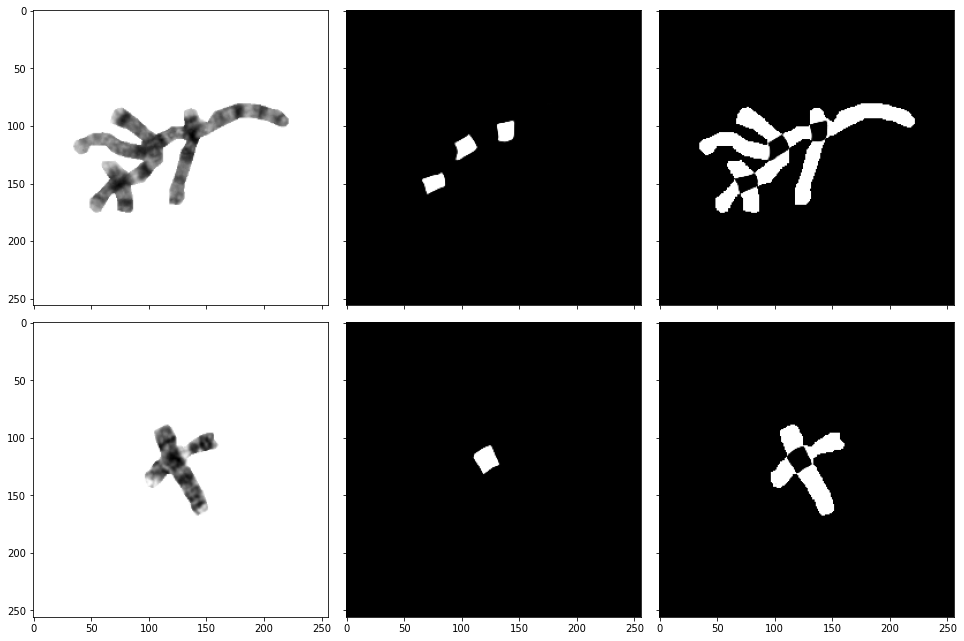

In [17]:
IMG_SIZE = 256
INPUT_PATH = "input"
OUTPUT_PATH = 'output region-guided UNet++'

outputFolderNames = os.listdir(OUTPUT_PATH)
for folder in outputFolderNames:
    shutil.rmtree(os.path.join(OUTPUT_PATH, folder))

# get all images' name
imgNames = os.listdir(INPUT_PATH)

fig, ax = plt.subplots(len(imgNames), 3, sharex=True, sharey=True, figsize=(4.5*3, 4.5 * len(imgNames)))

for i in range(len(imgNames)):
    # get the image's name
    imageName = imgNames[i]

    # load image and resize
    ori_image = Image.open(os.path.join(INPUT_PATH, imageName)).convert('RGB')    
    ori_image = ori_image.resize((256, 256))
    image = x_transforms(ori_image)
    image = image.reshape((1,3,256,256))

    # get overlapping and non-overlapping images
    results = model(torch.Tensor(image))
    ori_image = np.array(ori_image)
    overlapped = results[0][0][0].detach().numpy() * 255
    non_overlapped = results[1][0][0].detach().numpy() * 255

    ax[i][0].imshow(ori_image, cmap='gray')
    ax[i][1].imshow(overlapped, cmap='gray')
    ax[i][2].imshow(non_overlapped, cmap='gray')
    fig.tight_layout()

    # saving the result
    output_path = os.path.join(OUTPUT_PATH, str(i))
    if not os.path.exists(output_path):
        os.mkdir(output_path)

    os.path.join(output_path, "non_overlapped.png")

    cv2.imwrite(os.path.join(output_path, "original.png"), ori_image)
    cv2.imwrite(os.path.join(output_path, "overlapped.png"), overlapped)
    cv2.imwrite(os.path.join(output_path, "non_overlapped.png"), non_overlapped)
plt.show()